In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import cv2
import json
import pandas as pd
from pandas import read_csv
import json
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
from lime import lime_tabular

In [3]:
# 1. Wir müssen unsere Daten laden 
# 2. Daten prozessieren -> Daten alle kleinschreiben, und dann in Vektor umwandeln 
# 3. One hot encoding -> stellt bestimmten Wert als 1 der 0 dar 

In [4]:
#lade einfache Daten und wandle in einen Dataframe um
with open('testEinfach1.json') as einfachJson:
    json_einfach_for_einfachData = json.load(einfachJson)

#das sind alle Events mit Element id von einfach
reduzed_json_einfach_for_einfachData = []

#das sind alle Events mit Element id von einfach
for index, item in enumerate(json_einfach_for_einfachData):
    elementId = item.get('elementId')
    if (elementId == 'inputCountry' or elementId == 'inputHouse' or elementId ==  'inputPet' or elementId ==  'inputHand' or elementId ==  'inputBundesland' or elementId == 'inputEasyQuestion' or (elementId == 'window' and item.get('siteName') == 'TestEinfach')):
        reduzed_json_einfach_for_einfachData.append(item)

In [5]:
with open('testEinfach1.json') as einfachJson:
    json_einfach_for_missing_keys = json.load(einfachJson)

#array mit allen Events die property key haben in TestEinfach
array_with_keys_from_einfach = []

#get all events with key 
for index, item in enumerate(json_einfach_for_missing_keys):
    if(item.get('key')):
        array_with_keys_from_einfach.append(item)

#array mit allen Events die jetzt richtig zugeteilt wurden zu TestSchwer
items_with_correct_keys = []

#get all events which are actually in TestSchwer
for index, item in enumerate(array_with_keys_from_einfach):
    elementId = item.get('elementId')
    if(elementId == 'inputHobby' or elementId =='inputCancelor' or elementId =='inputTemperature' or elementId =='inputDays' or elementId =='inputRivers' or elementId =='inputDifficultQuestion'):
        item['siteName'] = 'TestSchwer'
        items_with_correct_keys.append(item)


In [6]:
with open('testSchwer1.json') as schwerJson: 
    json_schwer = json.load(schwerJson)

#richtige schwer Events + array mit allen Events die jetzt richtig zugeteilt wurden zu TestSchwer
extended_json_schwer = json_schwer + items_with_correct_keys

#extended_json_schwer => alle Schwer Events 
#reduzed_json_einfach_for_einfachData => alle Einfach Events


In [7]:
# ohne 'key' Spalte
df_schwer = pd.DataFrame(extended_json_schwer)
df_schwer_without_key = df_schwer.drop(['key'], axis=1)
#6470 Events ohne scroll
df_schwer_without_scroll = df_schwer_without_key.loc[df_schwer_without_key["type"] !="scroll"]

df_einfach = pd.DataFrame(reduzed_json_einfach_for_einfachData)
df_einfach_without_key = df_einfach.drop(['key'], axis=1)
#1679 Events ohne scroll
df_einfach_without_scroll = df_einfach_without_key.loc[df_einfach_without_key["type"] !="scroll"]
df_einfach_without_scroll.head()

,elementId,timeStamp,type,siteName,date,session
0,inputPet,824.2999999988824,mouseover,TestEinfach,2022-10-17T13:35:24.171Z,1ff12350-5d06-5a07-9f0d-96a9a3942adb
1,inputPet,858.2999999988824,mouseout,TestEinfach,2022-10-17T13:35:24.205Z,1ff12350-5d06-5a07-9f0d-96a9a3942adb
2,inputCountry,2005.2999999988824,mouseover,TestEinfach,2022-10-17T13:35:25.361Z,1ff12350-5d06-5a07-9f0d-96a9a3942adb
3,inputCountry,2296.5,focus,TestEinfach,2022-10-17T13:35:25.652Z,1ff12350-5d06-5a07-9f0d-96a9a3942adb
4,inputCountry,2875.2999999988824,mouseout,TestEinfach,2022-10-17T13:35:26.229Z,1ff12350-5d06-5a07-9f0d-96a9a3942adb


In [8]:
sessionIdSchwer = df_schwer['session']
sessionIdEinfach = df_einfach['session']

df_einfach['is_duplicated'] = df_einfach.duplicated('session')
#86 ids auf Seite Einfach
setEinfach = set(sessionIdEinfach)
length = len(setEinfach)

#59 ids auf Seite Schwer
df_schwer['is_duplicated'] = df_schwer.duplicated('session')
setSchwer = set(sessionIdSchwer)
lengthSchwer = len(setSchwer)


In [9]:
in_schwer_but_not_in_einfach = setSchwer - setEinfach
in_einfach_but_not_in_schwer = setEinfach - setSchwer

array_einfach = list(in_einfach_but_not_in_schwer)
array_schwer = list(in_schwer_but_not_in_einfach)

# Anzahl Events | sessionId | Klasse 
# 20 | 95 | 0
# 30 | 113 | 0
# 10 | 113 | 1


In [10]:
#52 Teilnehmer bzw. Sessions
df_einfach_without_ids = df_einfach_without_scroll[~df_einfach_without_scroll['session'].isin(array_einfach)]
df_schwer_without_ids = df_schwer_without_scroll[~df_schwer_without_scroll['session'].isin(array_schwer)]

In [11]:
df_schwer_without_key.loc[df_schwer_without_key["type"] !="scroll"]
df_einfach_without_ids_focus = df_einfach_without_ids.loc[df_einfach_without_ids['type']=='focus']
df_einfach_without_ids_blur = df_einfach_without_ids.loc[df_einfach_without_ids['type']=='blur']

df_einfach_without_ids_focusBlur = pd.concat([df_einfach_without_ids_focus, df_einfach_without_ids_blur])
df_sort_sessionId = df_einfach_without_ids_focusBlur.sort_values(by=['session','elementId','date'], ascending=[False, False, True])
df_sort_sessionId['timeStamp'] = df_sort_sessionId['timeStamp'].astype(float)
#wieso ohne window --> da kein Event gesendet wird bei window wenn es auf focus steht, es gehört auch nicht zu den Input Elementen 
df_sort_without_window = df_sort_sessionId.loc[df_sort_sessionId["elementId"] !="window"]

In [12]:
df_focus = df_sort_without_window.loc[df_sort_without_window['type'] == 'focus']
df_blur = df_sort_without_window.loc[df_sort_without_window['type'] == 'blur']

In [13]:
from datetime import datetime

df_blur['real_date'] = df_blur['date'].astype('datetime64[ns]')
df_focus['real_date'] = df_focus['date'].astype('datetime64[ns]')

df_focus.reset_index(inplace=True)
df_blur.reset_index(inplace=True)

df_focus['duration'] = (df_blur['real_date'] - df_focus['real_date']).dt.total_seconds()

<ipython-input-13-a7dab511ec61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_blur['real_date'] = df_blur['date'].astype('datetime64[ns]')
<ipython-input-13-a7dab511ec61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_focus['real_date'] = df_focus['date'].astype('datetime64[ns]')
<ipython-input-13-a7dab511ec61>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [14]:
df_focusBlur = df_focus.replace('focus', 'focusBlur')
df_focusBlur.drop(['index', 'timeStamp', 'date'], axis=1)

,elementId,type,siteName,session,real_date,duration
0,inputPet,focusBlur,TestEinfach,fd6c4243-c30d-f1ff-f22e-c2f56b2cf901,2022-10-18 13:46:17.383,1.669
1,inputHouse,focusBlur,TestEinfach,fd6c4243-c30d-f1ff-f22e-c2f56b2cf901,2022-10-18 13:46:14.057,3.320
2,inputHand,focusBlur,TestEinfach,fd6c4243-c30d-f1ff-f22e-c2f56b2cf901,2022-10-18 13:46:19.057,2.782
3,inputEasyQuestion,focusBlur,TestEinfach,fd6c4243-c30d-f1ff-f22e-c2f56b2cf901,2022-10-18 13:46:25.455,2.697
4,inputCountry,focusBlur,TestEinfach,fd6c4243-c30d-f1ff-f22e-c2f56b2cf901,2022-10-18 13:46:11.105,2.951
...,...,...,...,...,...,...
304,inputHouse,focusBlur,TestEinfach,057dc296-346a-f2ee-76a7-09440b8283b8,2022-10-17 13:40:50.202,7.232
305,inputHand,focusBlur,TestEinfach,057dc296-346a-f2ee-76a7-09440b8283b8,2022-10-17 13:41:14.403,2.702
306,inputEasyQuestion,focusBlur,TestEinfach,057dc296-346a-f2ee-76a7-09440b8283b8,2022-10-17 13:41:21.279,1.418
307,inputCountry,focusBlur,TestEinfach,057dc296-346a-f2ee-76a7-09440b8283b8,2022-10-17 13:40:44.521,5.679


In [15]:
#remove columns
df_removed_columns_einfach = df_einfach_without_ids.drop(['timeStamp', 'type', 'date'], axis=1)
df_removed_columns_schwer = df_schwer_without_ids.drop(['timeStamp', 'type', 'date'], axis=1)

In [16]:
#replace values of columns 
df_new_siteName_einfach = df_removed_columns_einfach.replace('TestEinfach', 0)
df_new_siteName_schwer = df_removed_columns_schwer.replace('TestSchwer', 1)

arrayOfEvents = ['clickHere', 'buttonYes', 'nextButton', 'alibiClick']

df_removed_inputFields_schwer = df_new_siteName_schwer[~df_new_siteName_schwer['elementId'].isin(arrayOfEvents)]

In [17]:
from random import random
from secrets import choice

#df_merged_einfach_schwer = pd.concat([df_removed_inputFields_schwer, df_new_siteName_einfach])
array_of_ids_einfach = df_new_siteName_einfach['session'].value_counts().index.tolist()
array_of_ids_schwer = df_removed_inputFields_schwer['session'].value_counts().index.tolist()

random_numbers_einfach = np.random.randint(101,1000,size=len(array_of_ids_einfach))
random_numbers_schwer = np.random.choice([i for i in range(101,1000) if i not in random_numbers_einfach], size=len(array_of_ids_schwer))

In [33]:
df_replaced_session_einfach = df_new_siteName_einfach.replace(array_of_ids_einfach, random_numbers_einfach)
df_replaced_session_schwer = df_removed_inputFields_schwer.replace(array_of_ids_schwer, random_numbers_schwer)

print(df_replaced_session_einfach)
print(df_replaced_session_schwer)

pd.set_option("display.max_rows", None, "display.max_columns", None)

#df_replaced_session_einfach['session'].value_counts()
#df_replaced_session_schwer['session'].value_counts()


              elementId  siteName  session
0              inputPet         0      202
1              inputPet         0      202
2          inputCountry         0      202
3          inputCountry         0      202
4          inputCountry         0      202
5            inputHouse         0      202
6            inputHouse         0      202
7          inputCountry         0      202
8          inputCountry         0      202
9            inputHouse         0      202
10             inputPet         0      202
11           inputHouse         0      202
12             inputPet         0      202
13             inputPet         0      202
14            inputHand         0      202
15            inputHand         0      202
16      inputBundesland         0      202
17      inputBundesland         0      202
18    inputEasyQuestion         0      202
19         inputCountry         0      202
20             inputPet         0      202
21             inputPet         0      202
22      inp

In [19]:
#create new Dataframe 
new_df_einfach = pd.DataFrame(df_replaced_session_einfach['session'].value_counts().reset_index().values, columns=["session", "eventCount"])
class_num_einfach = 0
df_final_einfach = new_df_einfach.assign(class_num=class_num_einfach)

new_df_schwer = pd.DataFrame(df_replaced_session_schwer['session'].value_counts().reset_index().values, columns=["session", "eventCount"])
class_num_schwer = 1
df_final_schwer = new_df_schwer.assign(class_num=class_num_schwer)

df_final_together = pd.concat([df_final_einfach, df_final_schwer])

In [20]:
from sklearn.utils import shuffle

result = shuffle(df_final_together)

In [21]:
'''
Recognize whether a column is numerical or categorical.
:parameter
    :param dtf: dataframe - input data
    :param col: str - name of the column to analyze
    :param max_cat: num - max number of unique values to recognize a column as categorical
:return
    "cat" if the column is categorical or "num" otherwise
'''
def utils_recognize_type(dtf, col, max_cat=20):
    if (result[col].dtype == "TestEinfach") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

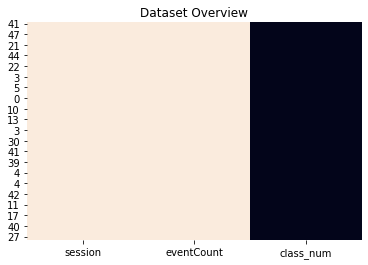

 Categerocial   Numeric   NaN 


In [22]:
dic_cols = {col:utils_recognize_type(result, col, max_cat=20) for col in result.columns}
heatmap = result.isnull()
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [23]:

result = result.rename(columns={"class_num":"Y"})

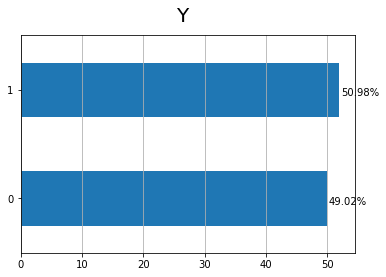

In [24]:
y = "Y"
ax = result[y].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)
plt.show()

[]

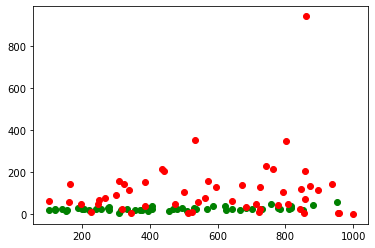

In [25]:
#plot data => hier ist schon zu sehen, dass die schwere Seite viel aussagekräftiger ist

x = df_final_einfach['session']
y = df_final_einfach['eventCount']
plt.scatter(x,y,c='green')

x_schwer = df_final_schwer['session']
y_schwer = df_final_schwer['eventCount']

plt.scatter(x_schwer,y_schwer, c='red')
plt.plot()

In [26]:
df_final_einfach_schwer = pd.concat([df_final_einfach, df_final_schwer])
df_final_einfach_schwer.corr()

#randomize data 
#df_shuffle_data = df_final_einfach_schwer.sample(frac=1).reset_index(drop=True)


,session,eventCount,class_num
session,1.000000,0.205443,0.231462
eventCount,0.205443,1.000000,0.391065
class_num,0.231462,0.391065,1.000000


In [27]:
#split training data and test data with 
from sklearn.model_selection import train_test_split

#train, test = train_test_split(df_shuffle_data, test_size=0.2)
#contains the data that we will use to make predictions
X_lin = df_final_einfach_schwer.drop(['class_num'], axis=1)
#which contains the data that we are trying to predict
Y_lin = df_final_einfach_schwer['class_num']

X_lin_train, X_lin_test, Y_lin_train, Y_lin_test = train_test_split(X_lin, Y_lin, test_size=0.3, random_state=42, shuffle=True)

In [28]:
#test without Test Data 
from sklearn.tree import DecisionTreeRegressor
Y = df_final_einfach_schwer['class_num']
X = df_final_einfach_schwer.drop(['class_num'], axis=1)

iowa_model = DecisionTreeRegressor(random_state=1)
iowa_model.fit(X, Y)

iowa_model.predict(X)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [29]:
# Test MeanSquaredError
from sklearn.metrics import mean_absolute_error

predicted_class = iowa_model.predict(X)
mean_absolute_error(Y, predicted_class)

0.0

In [30]:
train_X, val_X, train_y, val_y = train_test_split(X, Y, random_state = 0)
# Define model

def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

In [31]:
from sklearn.ensemble import RandomForestRegressor

# Define the models
model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=0)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)

models = [model_1, model_2, model_3, model_4, model_5]

In [32]:
from sklearn.metrics import mean_absolute_error

# Function for comparing different models
def score_model(model, X_t=train_X, X_v=val_X, y_t=train_y, y_v=val_y):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

for i in range(0, len(models)):
    mae = score_model(models[i])
    print("Model %d MAE: %d" % (i+1, mae))

Model 1 MAE: 0
Model 2 MAE: 0


KeyError: 'absolute_error'

In [ ]:
from sklearn.linear_model import LinearRegression
Linear_model = LinearRegression()

Linear_model.fit(X_lin_train, Y_lin_train)
print(Linear_model.intercept_)


0.5564277991316937


In [ ]:
pred = Linear_model.predict(X_lin_test)
pred

Linear_model.score(X_lin_test, pred)
pred


array([0.4947665 , 0.71080885, 0.70101389, 0.62538436, 0.54323083,
       0.49131664, 0.56053561, 0.52772143, 0.44280519, 0.51700611,
       0.45051285, 0.42881848, 0.38597481, 0.38541094, 0.48550797,
       0.57257666, 0.53813617, 0.57321597, 0.48232126, 0.51422359,
       0.6304504 , 0.42237974, 0.44825693, 0.43630995, 0.51469412,
       0.51005957, 0.53143429, 0.48502878, 0.43101805, 0.51563341,
       0.50298167])

In [ ]:

for i, col_name in enumerate(X_lin_train.columns):
    print("The coefficients for {} is {}".format(col_name, Linear_model.coef_[1]))

The coefficients for session is 0.0014381513107259273
The coefficients for eventCount is 0.0014381513107259273
